In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tqdm import tqdm
from transformers import BertTokenizer, BertForMaskedLM
from datasets import load_dataset
from sklearn.metrics import classification_report
import numpy as np
import gensim.downloader as api
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Load AG News Dataset
print("Loading AG News Dataset...")
dataset = load_dataset('ag_news')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(text):
    return tokenizer(text, padding='max_length', truncation=True, return_tensors='pt', max_length=128)


In [75]:
dataset

DatasetDict({
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
})

In [93]:
dataset['train']['text'][2]

"Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums."

In [94]:
import pandas as pd
train_texts = pd.DataFrame(dataset['train']['text'], columns=['text'])

# Calculating the lengths of each text
train_texts['length'] = train_texts['text'].apply(len)

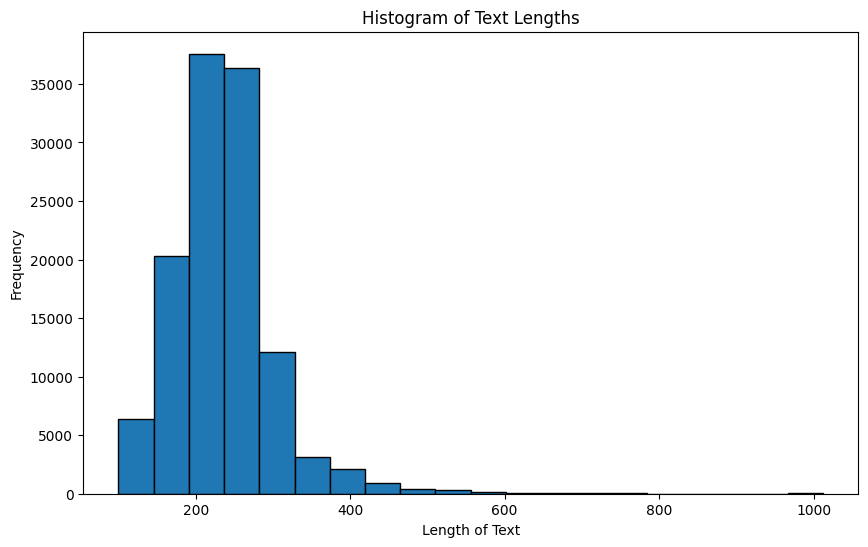

In [83]:
plt.figure(figsize=(10, 6))
plt.hist(train_texts['length'], bins=20, edgecolor='black')
plt.title('Histogram of Text Lengths')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()

In [91]:
train_texts[train_texts['length'] == 350].iloc[0]['text']

'Venezuelans Line Up to Vote on Chavez CARACAS, Venezuela - Summoned by bugle calls and the detonations of huge firecrackers, Venezuelans turned out in unprecedented numbers Sunday to vote on whether to force leftist President Hugo Chavez from office.    Some lines at polling places extended for 1.25 miles, stunning even veteran election monitors...'

In [ ]:
# Load Word2Vec Embeddings
print("Loading Word2Vec Embeddings...")
word2vec = api.load('word2vec-google-news-300')
def get_word2vec_embedding(tokens):
    embeddings = []
    for token in tokens:
        if token in word2vec:
            embeddings.append(word2vec[token])
    if len(embeddings) == 0:
        return np.zeros(word2vec.vector_size)
    return np.mean(embeddings, axis=0)

In [ ]:
class AGNewsDataset(data.Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        tokens = tokenizer.tokenize(self.texts[idx])
        embedding = get_word2vec_embedding(tokens)
        label = self.labels[idx]
        return torch.tensor(embedding, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [ ]:
# Function to calculate perplexity
def calculate_perplexity(texts, tokenizer, model):
    model.eval()
    perplexities = []
    for text in tqdm(texts, desc="Calculating Perplexity"):
        inputs = tokenizer(text, return_tensors='pt', max_length=128, truncation=True, padding='max_length').to(device)
        with torch.no_grad():
            outputs = model(**inputs, labels=inputs['input_ids'])
            loss = outputs.loss
            perplexity = torch.exp(loss).item()
            perplexities.append(perplexity)
    return perplexities


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 100, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(100 * (word2vec.vector_size // 2), 4)  # 4 classes in AG News

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

def train_and_evaluate(pruned_train_dataset):
    train_loader = data.DataLoader(pruned_train_dataset, batch_size=64, shuffle=True)
    model = CNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training
    print("Training CNN model...")
    for epoch in range(10):  # Fixed number of epochs for consistency
        model.train()
        for inputs, labels in tqdm(train_loader, desc=f"Training CNN Epoch {epoch+1}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Evaluate on train set
    print("Evaluating on train set...")
    model.eval()
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(train_loader, desc="Evaluating Train Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
    train_accuracy = 100 * train_correct / train_total

    # Evaluate on test set
    print("Evaluating on test set...")
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating Test Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_accuracy = 100 * test_correct / test_total
    
    return train_accuracy, test_accuracy


Loading AG News Dataset...
Loading Word2Vec Embeddings...
Training BERT language model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Tokenizing and preparing data for the language model...
Training the language model...


Training Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7500/7500 [53:04<00:00,  2.36it/s]


Calculating perplexity for the training data...


Calculating Perplexity: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [31:06<00:00, 64.29it/s]


Preparing test dataset...
Starting pruning and evaluation for each threshold...
Pruning dataset at 10% threshold...
Training CNN model...


Training CNN Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.75it/s]


Evaluating on train set...


Evaluating Train Set: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 23.30it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.87it/s]


Threshold 10%: Train Accuracy: 86.09%, Test Accuracy: 82.89%
Pruning dataset at 20% threshold...
Training CNN model...


Training CNN Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 20.84it/s]


Evaluating on train set...


Evaluating Train Set: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:17<00:00, 21.25it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.87it/s]


Threshold 20%: Train Accuracy: 87.30%, Test Accuracy: 86.63%
Pruning dataset at 30% threshold...
Training CNN model...


Training CNN Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 563/563 [00:28<00:00, 19.71it/s]


Evaluating on train set...


Evaluating Train Set: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 563/563 [00:27<00:00, 20.22it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.81it/s]


Threshold 30%: Train Accuracy: 88.41%, Test Accuracy: 87.22%
Pruning dataset at 40% threshold...
Training CNN model...


Training CNN Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:39<00:00, 18.79it/s]


Evaluating on train set...


Evaluating Train Set: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:38<00:00, 19.23it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.90it/s]


Threshold 40%: Train Accuracy: 88.69%, Test Accuracy: 87.17%
Pruning dataset at 50% threshold...
Training CNN model...


Training CNN Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:52<00:00, 18.00it/s]


Evaluating on train set...


Evaluating Train Set: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:50<00:00, 18.54it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.94it/s]


Threshold 50%: Train Accuracy: 89.31%, Test Accuracy: 87.63%
Pruning dataset at 60% threshold...
Training CNN model...


Training CNN Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1125/1125 [01:04<00:00, 17.57it/s]


Evaluating on train set...


Evaluating Train Set: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1125/1125 [01:03<00:00, 17.73it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.61it/s]


Threshold 60%: Train Accuracy: 89.32%, Test Accuracy: 87.49%
Pruning dataset at 70% threshold...
Training CNN model...


Training CNN Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1313/1313 [01:17<00:00, 16.97it/s]


Evaluating on train set...


Evaluating Train Set: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1313/1313 [01:17<00:00, 16.90it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.40it/s]


Threshold 70%: Train Accuracy: 90.01%, Test Accuracy: 88.09%
Pruning dataset at 80% threshold...
Training CNN model...


Training CNN Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:29<00:00, 16.68it/s]


Evaluating on train set...


Evaluating Train Set: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:28<00:00, 17.02it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.82it/s]


Threshold 80%: Train Accuracy: 90.03%, Test Accuracy: 87.99%
Pruning dataset at 90% threshold...
Training CNN model...


Training CNN Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [01:46<00:00, 15.92it/s]


Evaluating on train set...


Evaluating Train Set: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1688/1688 [01:42<00:00, 16.48it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.77it/s]


Threshold 90%: Train Accuracy: 90.29%, Test Accuracy: 88.91%
Plotting the results...


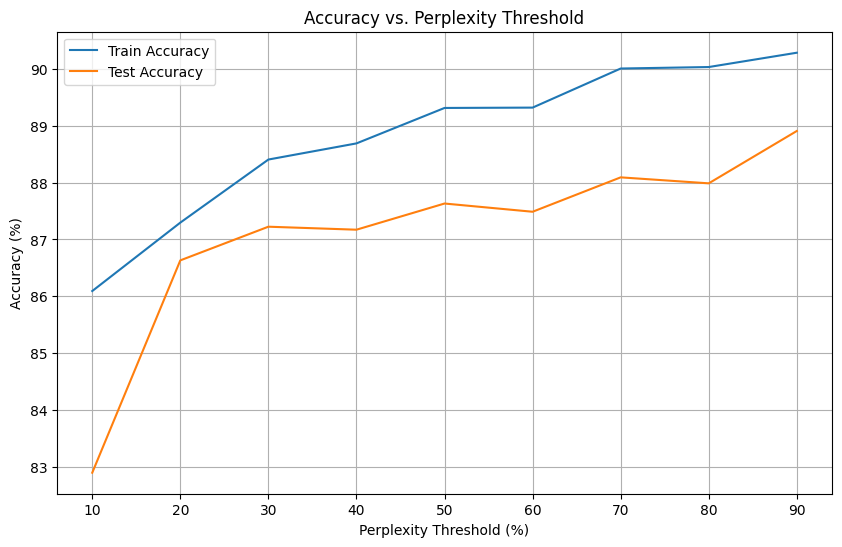

In [4]:
# Train a language model to get perplexity scores
print("Training BERT language model...")
lm_model = BertForMaskedLM.from_pretrained('bert-base-uncased').to(device)
lm_model.train()
optimizer = optim.Adam(lm_model.parameters(), lr=0.001)
train_texts = [item['text'] for item in dataset['train']]
train_labels = [item['label'] for item in dataset['train']]

# Tokenize and prepare data for the language model
print("Tokenizing and preparing data for the language model...")
lm_dataset = tokenizer(train_texts, padding='max_length', truncation=True, return_tensors='pt', max_length=128)
lm_dataset = data.TensorDataset(lm_dataset['input_ids'], lm_dataset['attention_mask'], torch.tensor(train_labels))
lm_loader = data.DataLoader(lm_dataset, batch_size=16, shuffle=True)

# Train the language model
print("Training the language model...")
for epoch in range(2):  # Short training for demonstration purposes
    for inputs, masks, _ in tqdm(lm_loader, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()
        inputs, masks = inputs.to(device), masks.to(device)
        outputs = lm_model(input_ids=inputs, attention_mask=masks, labels=inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()


# Calculate perplexity for the training data
print("Calculating perplexity for the training data...")
train_perplexities = calculate_perplexity(train_texts, tokenizer, lm_model)

# Prepare test dataset
print("Preparing test dataset...")
test_texts = [item['text'] for item in dataset['test']]
test_labels = [item['label'] for item in dataset['test']]
test_dataset = AGNewsDataset(test_texts, test_labels)
test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=False)


thresholds = np.arange(10, 100, 10)
train_accuracies = []
test_accuracies = []

print("Starting pruning and evaluation for each threshold...")
for threshold in thresholds:
    print(f"Pruning dataset at {threshold}% threshold...")
    pruned_indices = []
    for class_label in range(4): 
        class_indices = [i for i, label in enumerate(train_labels) if label == class_label]
        class_perplexities = [train_perplexities[i] for i in class_indices]
        class_threshold = np.percentile(class_perplexities, threshold)
        pruned_class_indices = [class_indices[i] for i, perplexity in enumerate(class_perplexities) if perplexity <= class_threshold]
        pruned_indices.extend(pruned_class_indices)
    
    pruned_train_texts = [train_texts[i] for i in pruned_indices]
    pruned_train_labels = [train_labels[i] for i in pruned_indices]
    pruned_train_dataset = AGNewsDataset(pruned_train_texts, pruned_train_labels)
    
    train_acc, test_acc = train_and_evaluate(pruned_train_dataset)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f'Threshold {threshold}%: Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

# Plotting the results
print("Plotting the results...")
plt.figure(figsize=(10, 6))
plt.plot(thresholds, train_accuracies, label='Train Accuracy')
plt.plot(thresholds, test_accuracies, label='Test Accuracy')
plt.xlabel('Perplexity Threshold (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Perplexity Threshold')
plt.legend()
plt.grid(True)
plt.show()


Plotting the results...


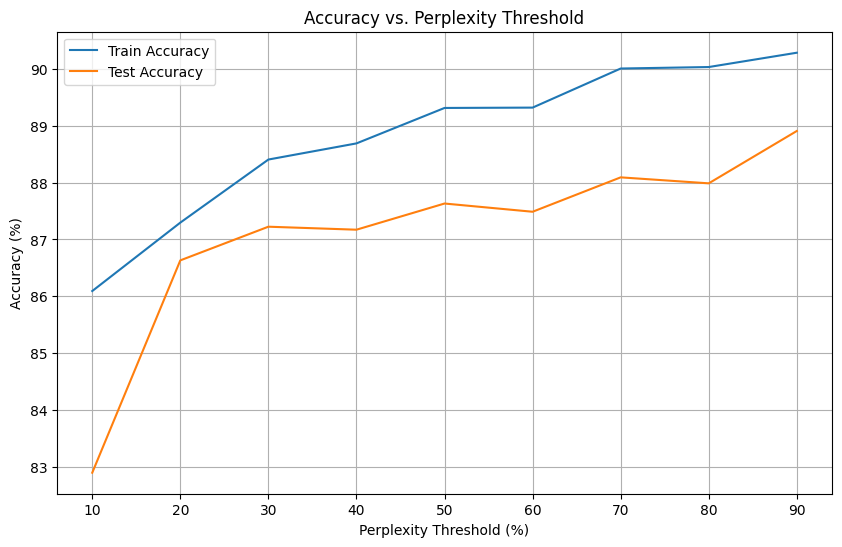

In [5]:
# Plotting the results
print("Plotting the results...")
plt.figure(figsize=(10, 6))
plt.plot(thresholds, train_accuracies, label='Train Accuracy')
plt.plot(thresholds, test_accuracies, label='Test Accuracy')
plt.xlabel('Perplexity Threshold (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Perplexity Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
threshold = 0.0016666666666666668
print(f"Pruning dataset at {threshold}% threshold...")
pruned_indices = []
for class_label in range(4):  # Assuming there are 4 classes
    class_indices = [i for i, label in enumerate(train_labels) if label == class_label]
    class_perplexities = [train_perplexities[i] for i in class_indices]
    class_threshold = np.percentile(class_perplexities, threshold)
    pruned_class_indices = [class_indices[i] for i, perplexity in enumerate(class_perplexities) if perplexity <= class_threshold]
    pruned_indices.extend(pruned_class_indices)

pruned_train_texts = [train_texts[i] for i in pruned_indices]
pruned_train_labels = [train_labels[i] for i in pruned_indices]
pruned_train_dataset = AGNewsDataset(pruned_train_texts, pruned_train_labels)

train_acc, test_acc = train_and_evaluate(pruned_train_dataset)
train_accuracies.append(train_acc)
test_accuracies.append(test_acc)
print(f'Threshold {threshold}%: Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

Pruning dataset at 0.0016666666666666668% threshold...
Training CNN model...


Training CNN Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 148.44it/s]


Evaluating on train set...


Evaluating Train Set: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 160.89it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.35it/s]

Threshold 0.0016666666666666668%: Train Accuracy: 50.00%, Test Accuracy: 25.00%


In [17]:
threshold = 2
print(f"Pruning dataset at {threshold}% threshold...")
pruned_indices = []
for class_label in range(4):  # Assuming there are 4 classes
    class_indices = [i for i, label in enumerate(train_labels) if label == class_label]
    class_perplexities = [train_perplexities[i] for i in class_indices]
    class_threshold = np.percentile(class_perplexities, threshold)
    pruned_class_indices = [class_indices[i] for i, perplexity in enumerate(class_perplexities) if perplexity <= class_threshold]
    print(len(pruned_class_indices))
    pruned_indices.extend(pruned_class_indices)

pruned_train_texts = [train_texts[i] for i in pruned_indices]
pruned_train_labels = [train_labels[i] for i in pruned_indices]
pruned_train_dataset = AGNewsDataset(pruned_train_texts, pruned_train_labels)

train_acc, test_acc = train_and_evaluate(pruned_train_dataset)
train_accuracies.append(train_acc)
test_accuracies.append(test_acc)
print(f'Threshold {threshold}%: Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

Pruning dataset at 2% threshold...
600
600
600
600
Training CNN model...


Training CNN Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.87it/s]


Evaluating on train set...


Evaluating Train Set: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 26.62it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.46it/s]

Threshold 2%: Train Accuracy: 84.25%, Test Accuracy: 80.34%


In [18]:
threshold = 1.6666666666666668
print(f"Pruning dataset at {threshold}% threshold...")
pruned_indices = []
for class_label in range(4):  # Assuming there are 4 classes
    class_indices = [i for i, label in enumerate(train_labels) if label == class_label]
    class_perplexities = [train_perplexities[i] for i in class_indices]
    class_threshold = np.percentile(class_perplexities, threshold)
    pruned_class_indices = [class_indices[i] for i, perplexity in enumerate(class_perplexities) if perplexity <= class_threshold]
    print(len(pruned_class_indices))
    pruned_indices.extend(pruned_class_indices)

pruned_train_texts = [train_texts[i] for i in pruned_indices]
pruned_train_labels = [train_labels[i] for i in pruned_indices]
pruned_train_dataset = AGNewsDataset(pruned_train_texts, pruned_train_labels)

train_acc, test_acc = train_and_evaluate(pruned_train_dataset)
train_accuracies.append(train_acc)
test_accuracies.append(test_acc)
print(f'Threshold {threshold}%: Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

Pruning dataset at 1.6666666666666667% threshold...
500
500
500
500
Training CNN model...


Training CNN Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 26.70it/s]


Evaluating on train set...


Evaluating Train Set: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 27.49it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.80it/s]

Threshold 1.6666666666666667%: Train Accuracy: 79.80%, Test Accuracy: 71.95%


In [19]:
threshold = 0.16666666666666667
print(f"Pruning dataset at {threshold}% threshold...")
pruned_indices = []
for class_label in range(4):  # Assuming there are 4 classes
    class_indices = [i for i, label in enumerate(train_labels) if label == class_label]
    class_perplexities = [train_perplexities[i] for i in class_indices]
    class_threshold = np.percentile(class_perplexities, threshold)
    pruned_class_indices = [class_indices[i] for i, perplexity in enumerate(class_perplexities) if perplexity <= class_threshold]
    print(len(pruned_class_indices))
    pruned_indices.extend(pruned_class_indices)

pruned_train_texts = [train_texts[i] for i in pruned_indices]
pruned_train_labels = [train_labels[i] for i in pruned_indices]
pruned_train_dataset = AGNewsDataset(pruned_train_texts, pruned_train_labels)

train_acc, test_acc = train_and_evaluate(pruned_train_dataset)
train_accuracies.append(train_acc)
test_accuracies.append(test_acc)
print(f'Threshold {threshold}%: Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

Pruning dataset at 0.16666666666666666% threshold...
50
50
50
50
Training CNN model...


Training CNN Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 35.76it/s]


Evaluating on train set...


Evaluating Train Set: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 36.98it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.77it/s]

Threshold 0.16666666666666666%: Train Accuracy: 46.50%, Test Accuracy: 45.78%


In [104]:
def train_and_evaluate(pruned_train_dataset, n_epochs = 100):
    train_loader = data.DataLoader(pruned_train_dataset, batch_size=64, shuffle=True)
    model = CNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training
    print("Training CNN model...")
    for epoch in range(n_epochs):  # Fixed number of epochs for consistency
        model.train()
        for inputs, labels in tqdm(train_loader, desc=f"Training CNN Epoch {epoch+1}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Evaluate on train set
    print("Evaluating on train set...")
    model.eval()
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(train_loader, desc="Evaluating Train Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
    train_accuracy = 100 * train_correct / train_total

    # Evaluate on test set
    print("Evaluating on test set...")
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating Test Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_accuracy = 100 * test_correct / test_total
    
    return train_accuracy, test_accuracy

In [26]:
threshold = 0.16666666666666667
print(f"Pruning dataset at {threshold}% threshold...")
pruned_indices = []
for class_label in range(4):  # Assuming there are 4 classes
    class_indices = [i for i, label in enumerate(train_labels) if label == class_label]
    class_perplexities = [train_perplexities[i] for i in class_indices]
    class_threshold = np.percentile(class_perplexities, threshold)
    pruned_class_indices = [class_indices[i] for i, perplexity in enumerate(class_perplexities) if perplexity <= class_threshold]
    print(len(pruned_class_indices))
    pruned_indices.extend(pruned_class_indices)

pruned_train_texts = [train_texts[i] for i in pruned_indices]
pruned_train_labels = [train_labels[i] for i in pruned_indices]
pruned_train_dataset = AGNewsDataset(pruned_train_texts, pruned_train_labels)

train_acc, test_acc = train_and_evaluate(pruned_train_dataset)
train_accuracies.append(train_acc)
test_accuracies.append(test_acc)
print(f'Threshold {threshold}%: Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

Pruning dataset at 0.16666666666666666% threshold...
50
50
50
50
Training CNN model...


Training CNN Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 32.24it/s]


Evaluating on train set...


Evaluating Train Set: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 35.09it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:07<00:00, 15.71it/s]

Threshold 0.16666666666666666%: Train Accuracy: 97.00%, Test Accuracy: 71.82%


In [97]:
train_texts

,text,length
0,Wall St. Bears Claw Back Into the Black (Reute...,144
1,Carlyle Looks Toward Commercial Aerospace (Reu...,266
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,232
3,Iraq Halts Oil Exports from Main Southern Pipe...,256
4,"Oil prices soar to all-time record, posing new...",234
...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,221
119996,Renteria signing a top-shelf deal Red Sox gene...,308
119997,Saban not going to Dolphins yet The Miami Dolp...,247
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,370


In [ ]:
threshold = 0.6666666666666667
print(f"Pruning dataset at {threshold}% threshold...")
pruned_indices = []
for class_label in range(4):  # Assuming there are 4 classes
    class_indices = [i for i, label in enumerate(train_labels) if label == class_label]
    class_perplexities = [train_perplexities[i] for i in class_indices]
    class_threshold = np.percentile(class_perplexities, threshold)
    pruned_class_indices = [class_indices[i] for i, perplexity in enumerate(class_perplexities) if perplexity <= class_threshold]
    print(len(pruned_class_indices))
    pruned_indices.extend(pruned_class_indices)

pruned_train_texts = [train_texts.iloc[i].values[0] for i in pruned_indices]
pruned_train_labels = [train_labels[i] for i in pruned_indices]
pruned_train_dataset = AGNewsDataset(pruned_train_texts, pruned_train_labels)

train_acc, test_acc = train_and_evaluate(pruned_train_dataset)
train_accuracies.append(train_acc)
test_accuracies.append(test_acc)
print(f'Threshold {threshold}%: Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

In [28]:
threshold = 100 - 0.16666666666666667
print(f"Pruning dataset at {threshold}% threshold...")
pruned_indices = []
for class_label in range(4):  # Assuming there are 4 classes
    class_indices = [i for i, label in enumerate(train_labels) if label == class_label]
    class_perplexities = [train_perplexities[i] for i in class_indices]
    class_threshold = np.percentile(class_perplexities, threshold)
    pruned_class_indices = [class_indices[i] for i, perplexity in enumerate(class_perplexities) if perplexity >= class_threshold]
    print(len(pruned_class_indices))
    pruned_indices.extend(pruned_class_indices)

pruned_train_texts = [train_texts[i] for i in pruned_indices]
pruned_train_labels = [train_labels[i] for i in pruned_indices]
pruned_train_dataset = AGNewsDataset(pruned_train_texts, pruned_train_labels)

train_acc, test_acc = train_and_evaluate(pruned_train_dataset)
train_accuracies.append(train_acc)
test_accuracies.append(test_acc)
print(f'Threshold {threshold}%: Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

Pruning dataset at 99.83333333333333% threshold...
50
50
50
50
Training CNN model...


Training CNN Epoch 100: 100%|█████████████████████| 4/4 [00:00<00:00,  8.47it/s]


Evaluating on train set...


Evaluating Train Set: 100%|███████████████████████| 4/4 [00:00<00:00,  8.87it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████| 119/119 [00:07<00:00, 15.73it/s]

Threshold 99.83333333333333%: Train Accuracy: 93.50%, Test Accuracy: 71.82%


In [29]:
threshold = 100 - 2
print(f"Pruning dataset at {threshold}% threshold...")
pruned_indices = []
for class_label in range(4):  # Assuming there are 4 classes
    class_indices = [i for i, label in enumerate(train_labels) if label == class_label]
    class_perplexities = [train_perplexities[i] for i in class_indices]
    class_threshold = np.percentile(class_perplexities, threshold)
    pruned_class_indices = [class_indices[i] for i, perplexity in enumerate(class_perplexities) if perplexity >= class_threshold]
    print(len(pruned_class_indices))
    pruned_indices.extend(pruned_class_indices)

pruned_train_texts = [train_texts[i] for i in pruned_indices]
pruned_train_labels = [train_labels[i] for i in pruned_indices]
pruned_train_dataset = AGNewsDataset(pruned_train_texts, pruned_train_labels)

train_acc, test_acc = train_and_evaluate(pruned_train_dataset)
train_accuracies.append(train_acc)
test_accuracies.append(test_acc)
print(f'Threshold {threshold}%: Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

Pruning dataset at 98% threshold...
600
600
600
600
Training CNN model...


Training CNN Epoch 100: 100%|███████████████████| 38/38 [00:04<00:00,  8.34it/s]


Evaluating on train set...


Evaluating Train Set: 100%|█████████████████████| 38/38 [00:04<00:00,  8.41it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████| 119/119 [00:07<00:00, 15.78it/s]

Threshold 98%: Train Accuracy: 98.54%, Test Accuracy: 58.96%


# EL2N and Memorization

In [55]:

def calculate_el2n(texts, tokenizer, model, steps=250):
    model.eval()
    el2n_scores = []

    for text in tqdm(texts, desc="Calculating EL2N"):
        inputs = tokenizer(text, return_tensors='pt', max_length=128, truncation=True, padding='max_length').to(device)
        outputs = model(**inputs)
        optimizer.zero_grad()
        logits = outputs.logits
        y_true = inputs['input_ids']

        # One-hot encode y_true
        y_true_one_hot = torch.nn.functional.one_hot(y_true, num_classes=logits.size(-1)).float()

        # Compute the L2 norm of the error vector for each sequence
        error_vector = torch.norm(logits - y_true_one_hot, p=2, dim=-1)  # Sum over vocab dimension
        el2n_score = error_vector.mean().item()  # Mean over sequence length
        el2n_scores.append(el2n_score)
    
    return el2n_scores
    
# Function to calculate Memorization
def calculate_memorization(texts, tokenizer, model, M=32, N=32):
    model.eval()
    memorization_scores = []
    for text in tqdm(texts, desc="Calculating Memorization"):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=M+N).to(device)
        input_length = inputs['input_ids'].size(1)
        
        if input_length < M + N:
            M = input_length // 2
            N = input_length - M

        with torch.no_grad():
            outputs = model.generate(inputs['input_ids'][:, :M], max_length=M+N)
            original_tokens = inputs['input_ids'][:, M:M+N].cpu().numpy()
            generated_tokens = outputs[:, M:M+N].cpu().numpy()
            memorization_score = (original_tokens == generated_tokens).mean()
            memorization_scores.append(memorization_score)
    return memorization_scores



In [56]:
train_el2n = calculate_el2n(train_texts, tokenizer, lm_model)

Calculating Memorization:   0%|         | 179/120000 [00:58<10:56:14,  3.04it/s]


KeyboardInterrupt: 

In [59]:
def train_and_evaluate(pruned_train_dataset, n_epochs = 10):
    train_loader = data.DataLoader(pruned_train_dataset, batch_size=64, shuffle=True)
    model = CNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training
    print("Training CNN model...")
    for epoch in range(n_epochs):  # Fixed number of epochs for consistency
        model.train()
        for inputs, labels in tqdm(train_loader, desc=f"Training CNN Epoch {epoch+1}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Evaluate on train set
    print("Evaluating on train set...")
    model.eval()
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(train_loader, desc="Evaluating Train Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
    train_accuracy = 100 * train_correct / train_total

    # Evaluate on test set
    print("Evaluating on test set...")
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating Test Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_accuracy = 100 * test_correct / test_total
    
    return train_accuracy, test_accuracy

In [62]:
# Function to prune based on a given metric
def prune_dataset(scores, train_texts, train_labels, threshold, class_label):
    pruned_indices = []
    for class_label in range(4): 
        class_indices = [i for i, label in enumerate(train_labels) if label == class_label]
        class_scores = [scores[i] for i in class_indices]
        class_threshold = np.percentile(class_scores, threshold)
        pruned_class_indices = [class_indices[i] for i, score in enumerate(class_scores) if score <= class_threshold]
        pruned_indices.extend(pruned_class_indices)
    
    pruned_train_texts = [train_texts[i] for i in pruned_indices]
    len(pruned_train_texts)
    pruned_train_labels = [train_labels[i] for i in pruned_indices]
    pruned_train_dataset = AGNewsDataset(pruned_train_texts, pruned_train_labels)
    return pruned_train_dataset

In [60]:


# Prepare test dataset
print("Preparing test dataset...")
test_texts = [item['text'] for item in dataset['test']]
test_labels = [item['label'] for item in dataset['test']]
test_dataset = AGNewsDataset(test_texts, test_labels)
test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=False)

thresholds = np.arange(10, 100, 10)
train_accuracies_el2n = []
test_accuracies_el2n = []

# Evaluate EL2N
print("Starting pruning and evaluation based on EL2N scores...")
for threshold in thresholds:
    print(f"Pruning dataset at {threshold}% threshold based on EL2N scores...")
    pruned_train_dataset = prune_dataset(train_el2n, train_texts, train_labels, threshold, class_label=0)
    train_acc, test_acc = train_and_evaluate(pruned_train_dataset)
    train_accuracies_el2n.append(train_acc)
    test_accuracies_el2n.append(test_acc)
    print(f'Threshold {threshold}% (EL2N): Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

# Plotting the results for EL2N
print("Plotting the results for EL2N...")
plt.figure(figsize=(10, 6))
plt.plot(thresholds, train_accuracies_el2n, label='Train Accuracy (EL2N)')
plt.plot(thresholds, test_accuracies_el2n, label='Test Accuracy (EL2N)')
plt.xlabel('EL2N Threshold (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. EL2N Threshold')
plt.legend()
plt.grid(True)
plt.show()


Preparing test dataset...
Starting pruning and evaluation based on EL2N scores...
Pruning dataset at 10% threshold based on EL2N scores...
Training CNN model...


Training CNN Epoch 10: 100%|██████████████████| 221/221 [00:10<00:00, 21.74it/s]


Evaluating on train set...


Evaluating Train Set: 100%|███████████████████| 221/221 [00:09<00:00, 22.45it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████| 119/119 [00:07<00:00, 15.78it/s]


Threshold 10% (EL2N): Train Accuracy: 85.93%, Test Accuracy: 82.93%
Pruning dataset at 20% threshold based on EL2N scores...
Training CNN model...


Training CNN Epoch 10: 100%|██████████████████| 456/456 [00:22<00:00, 20.38it/s]


Evaluating on train set...


Evaluating Train Set: 100%|███████████████████| 456/456 [00:22<00:00, 20.71it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████| 119/119 [00:07<00:00, 15.88it/s]


Threshold 20% (EL2N): Train Accuracy: 87.69%, Test Accuracy: 86.71%
Pruning dataset at 30% threshold based on EL2N scores...
Training CNN model...


Training CNN Epoch 1:  18%|███▍               | 125/695 [00:06<00:30, 18.83it/s]


KeyboardInterrupt: 

In [69]:
# Function to prune based on a given metric
def prune_dataset(scores, train_texts, train_labels, threshold):
    pruned_indices = []
    for class_label in range(4):  # Assuming there are 4 classes
        class_indices = [i for i, label in enumerate(train_labels) if label == class_label]
        class_scores = [scores[i] for i in class_indices]
        class_threshold = np.percentile(class_scores, threshold)
        pruned_class_indices = [class_indices[i] for i, score in enumerate(class_scores) if score >= class_threshold]
        print(len(pruned_class_indices))
        pruned_indices.extend(pruned_class_indices)
    
    pruned_train_texts = [train_texts[i] for i in pruned_indices]
    pruned_train_labels = [train_labels[i] for i in pruned_indices]
    pruned_train_dataset = AGNewsDataset(pruned_train_texts, pruned_train_labels)
    return pruned_train_dataset
    
threshold = 98
pruned_train_dataset = prune_dataset(train_el2n, train_texts, train_labels, threshold)
train_acc, test_acc = train_and_evaluate(pruned_train_dataset)

print(f'Threshold {threshold}% (EL2N): Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')


649
719
699
705
Training CNN model...


Training CNN Epoch 10: 100%|████████████████████| 44/44 [00:05<00:00,  8.54it/s]


Evaluating on train set...


Evaluating Train Set: 100%|█████████████████████| 44/44 [00:05<00:00,  8.62it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████| 119/119 [00:07<00:00, 15.81it/s]

Threshold 98% (EL2N): Train Accuracy: 90.33%, Test Accuracy: 67.01%


In [71]:
# Function to prune based on a given metric
def prune_dataset(scores, train_texts, train_labels, threshold):
    pruned_indices = []
    for class_label in range(4):  # Assuming there are 4 classes
        class_indices = [i for i, label in enumerate(train_labels) if label == class_label]
        print(len(class_indices))
        class_scores = [scores[i] for i in class_indices]
        class_threshold = np.percentile(class_scores, threshold)
        pruned_class_indices = [class_indices[i] for i, score in enumerate(class_scores) if score <= class_threshold]
        print(len(pruned_class_indices))
        pruned_indices.extend(pruned_class_indices)
    
    pruned_train_texts = [train_texts[i] for i in pruned_indices]
    pruned_train_labels = [train_labels[i] for i in pruned_indices]
    pruned_train_dataset = AGNewsDataset(pruned_train_texts, pruned_train_labels)
    return pruned_train_dataset
    
threshold = 2
pruned_train_dataset = prune_dataset(train_el2n, train_texts, train_labels, threshold)
train_acc, test_acc = train_and_evaluate(pruned_train_dataset)

print(f'Threshold {threshold}% (EL2N): Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')


30000
959
30000
750
30000
638
30000
823
Training CNN model...


Training CNN Epoch 10: 100%|████████████████████| 50/50 [00:01<00:00, 25.22it/s]


Evaluating on train set...


Evaluating Train Set: 100%|█████████████████████| 50/50 [00:01<00:00, 25.90it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████| 119/119 [00:07<00:00, 15.79it/s]

Threshold 2% (EL2N): Train Accuracy: 84.07%, Test Accuracy: 80.32%


In [74]:
# Function to prune based on a given metric
def prune_dataset(scores, train_texts, train_labels, threshold):
    pruned_indices = []
    for class_label in range(4):  # Assuming there are 4 classes
        class_indices = [i for i, label in enumerate(train_labels) if label == class_label]
        print(len(class_indices))
        class_scores = [scores[i] for i in class_indices]
        class_threshold = np.percentile(class_scores, threshold)
        pruned_class_indices = [class_indices[i] for i, score in enumerate(class_scores) if score <= class_threshold]
        print(len(pruned_class_indices))
        pruned_indices.extend(pruned_class_indices)
    
    pruned_train_texts = [train_texts[i] for i in pruned_indices]
    pruned_train_labels = [train_labels[i] for i in pruned_indices]
    pruned_train_dataset = AGNewsDataset(pruned_train_texts, pruned_train_labels)
    return pruned_train_dataset
    
threshold = 0.16666667
pruned_train_dataset = prune_dataset(train_el2n, train_texts, train_labels, threshold)
train_acc, test_acc = train_and_evaluate(pruned_train_dataset)

print(f'Threshold {threshold}% (EL2N): Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')


30000
80
30000
147
30000
76
30000
91
Training CNN model...


Training CNN Epoch 10: 100%|██████████████████████| 7/7 [00:00<00:00, 31.08it/s]


Evaluating on train set...


Evaluating Train Set: 100%|███████████████████████| 7/7 [00:00<00:00, 32.47it/s]


Evaluating on test set...


Evaluating Test Set: 100%|████████████████████| 119/119 [00:07<00:00, 15.89it/s]

Threshold 0.16666667% (EL2N): Train Accuracy: 57.61%, Test Accuracy: 48.17%


In [ ]:
train_memorization = calculate_memorization(train_texts, tokenizer, lm_model)

train_accuracies_memorization = []
test_accuracies_memorization = []


# Evaluate Memorization
print("Starting pruning and evaluation based on Memorization scores...")
for threshold in thresholds:
    print(f"Pruning dataset at {threshold}% threshold based on Memorization scores...")
    pruned_train_dataset = prune_dataset(train_memorization, train_texts, train_labels, threshold, class_label=0)
    train_acc, test_acc = train_and_evaluate(pruned_train_dataset)
    train_accuracies_memorization.append(train_acc)
    test_accuracies_memorization.append(test_acc)
    print(f'Threshold {threshold}% (Memorization): Train Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')



# Plotting the results for Memorization
print("Plotting the results for Memorization...")
plt.figure(figsize=(10, 6))
plt.plot(thresholds, train_accuracies_memorization, label='Train Accuracy (Memorization)')
plt.plot(thresholds, test_accuracies_memorization, label='Test Accuracy (Memorization)')
plt.xlabel('Memorization Threshold (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Memorization Threshold')
plt.legend()
plt.grid(True)
plt.show()
